## 1. Setup and Imports

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


## 2. Dataset Loading and Preprocessing

We use the CelebA dataset (Aligned & Cropped version) with the following preprocessing:
- Center crop to 128x128 (focus on face region)
- Resize to 64x64 for computational efficiency
- Normalize to [0, 1] range

In [6]:
# Configuration
IMAGE_SIZE = 64
BATCH_SIZE = 128
LATENT_DIM = 128  # Latent space dimensionality
DATA_ROOT = './data'

# Data transforms
transform = transforms.Compose([
    transforms.CenterCrop(128),  # Crop to focus on face
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

# Create results directory
os.makedirs('results_portfolio3', exist_ok=True)

In [7]:
# Download CelebA dataset using kagglehub
import kagglehub
from torch.utils.data import Dataset
from PIL import Image
import glob

# Download latest version of CelebA from Kaggle
print("Downloading CelebA dataset from Kaggle (this may take a while on first run)...")
celeba_path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
print(f"✓ Path to dataset files: {celeba_path}")

c:\Users\2004l\Desktop\CV-assignment\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Path to dataset files: C:\Users\2004l\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2


In [8]:
# Custom Dataset class for CelebA from Kaggle
class CelebADataset(Dataset):
    """Custom Dataset for CelebA images downloaded from Kaggle."""
    
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Return image and dummy label (0) since we don't need labels for VAE
        return image, 0

# Find all images in the CelebA dataset
img_folder = os.path.join(celeba_path, 'img_align_celeba', 'img_align_celeba')
if not os.path.exists(img_folder):
    # Try alternative path structure
    img_folder = os.path.join(celeba_path, 'img_align_celeba')

all_images = sorted(glob.glob(os.path.join(img_folder, '*.jpg')))
print(f"Found {len(all_images)} images in {img_folder}")

# Split into train/test (use 90/10 split)
np.random.seed(42)
indices = np.random.permutation(len(all_images))
train_size = int(0.9 * len(all_images))

train_paths = [all_images[i] for i in indices[:train_size]]
test_paths = [all_images[i] for i in indices[train_size:]]

# Create datasets
train_dataset = CelebADataset(train_paths, transform=transform)
test_dataset = CelebADataset(test_paths, transform=transform)

print(f"\n{'='*50}")
print(f"Dataset loaded: CelebA (from Kaggle)")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"{'='*50}")

Found 202599 images in C:\Users\2004l\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2\img_align_celeba\img_align_celeba

Dataset loaded: CelebA (from Kaggle)
Training samples: 182339
Test samples: 20260


In [9]:
# Create data loaders
# For faster training, we can use a subset of the data
USE_SUBSET = True  # Set to False to use full dataset
SUBSET_SIZE = 30000  # Use 30k images for faster training

if USE_SUBSET:
    train_indices = np.random.choice(len(train_dataset), SUBSET_SIZE, replace=False)
    train_subset = Subset(train_dataset, train_indices)
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
else:
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 235
Test batches: 159


Batch shape: torch.Size([128, 3, 64, 64])


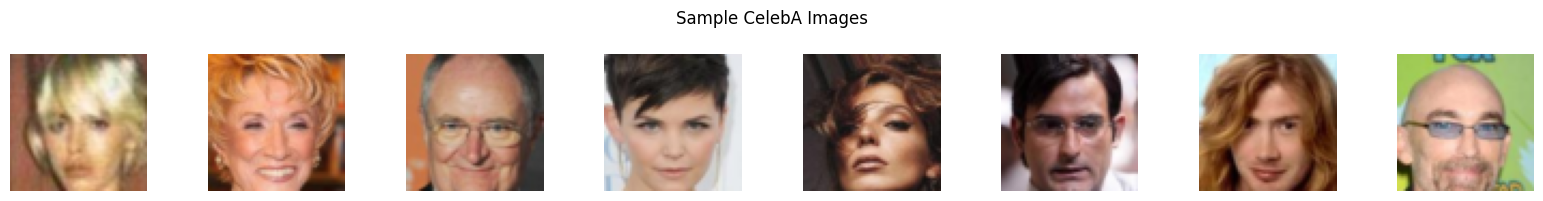

In [10]:
# Visualize some training images
def show_images(images, title="Sample Images", nrow=8):
    """Display a grid of images."""
    fig, axes = plt.subplots(1, min(len(images), nrow), figsize=(2*nrow, 2))
    if nrow == 1:
        axes = [axes]
    for i, (ax, img) in enumerate(zip(axes, images[:nrow])):
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).cpu().numpy()
        ax.imshow(np.clip(img, 0, 1))
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Get a batch of images
sample_batch, _ = next(iter(train_loader))
print(f"Batch shape: {sample_batch.shape}")
show_images(sample_batch[:8], "Sample CelebA Images")

---
## Task 1: Baseline VAE Implementation

### Architecture Design

Our VAE consists of:
- **Encoder**: Convolutional neural network that maps images to latent space parameters (μ, log σ²)
- **Decoder**: Transposed convolutional network that reconstructs images from latent vectors
- **Latent Dimension**: 128 (chosen to balance expressiveness and regularization)

### Loss Function
VAE Loss = Reconstruction Loss + KL Divergence
- Reconstruction: Binary Cross-Entropy or MSE
- KL Divergence: Regularizes latent space to approximate N(0, I)

In [11]:
class Encoder(nn.Module):
    """Convolutional encoder for VAE."""
    
    def __init__(self, latent_dim=128):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        
        # Convolutional layers
        # Input: 3 x 64 x 64
        self.conv_layers = nn.Sequential(
            # Layer 1: 3 -> 32, 64x64 -> 32x32
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            # Layer 2: 32 -> 64, 32x32 -> 16x16
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            # Layer 3: 64 -> 128, 16x16 -> 8x8
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            # Layer 4: 128 -> 256, 8x8 -> 4x4
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )
        
        # Flatten size: 256 * 4 * 4 = 4096
        self.flatten_size = 256 * 4 * 4
        
        # Latent space parameters
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_size, latent_dim)
    
    def forward(self, x):
        # Convolutional encoding
        h = self.conv_layers(x)
        h = h.view(h.size(0), -1)  # Flatten
        
        # Compute latent parameters
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        return mu, logvar


class Decoder(nn.Module):
    """Convolutional decoder for VAE."""
    
    def __init__(self, latent_dim=128):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        
        # Project and reshape
        self.fc = nn.Linear(latent_dim, 256 * 4 * 4)
        
        # Transposed convolutional layers
        self.deconv_layers = nn.Sequential(
            # Layer 1: 256 -> 128, 4x4 -> 8x8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            # Layer 2: 128 -> 64, 8x8 -> 16x16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            # Layer 3: 64 -> 32, 16x16 -> 32x32
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            # Layer 4: 32 -> 3, 32x32 -> 64x64
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),  # Output in [0, 1]
        )
    
    def forward(self, z):
        # Project and reshape
        h = self.fc(z)
        h = h.view(h.size(0), 256, 4, 4)
        
        # Deconvolutional decoding
        x_recon = self.deconv_layers(h)
        
        return x_recon


class VAE(nn.Module):
    """Variational Autoencoder."""
    
    def __init__(self, latent_dim=128, beta=1.0):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta  # β parameter for β-VAE
        
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = μ + σ * ε"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        # Encode
        mu, logvar = self.encoder(x)
        
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        
        # Decode
        x_recon = self.decoder(z)
        
        return x_recon, mu, logvar
    
    def loss_function(self, x, x_recon, mu, logvar):
        """Compute VAE loss: reconstruction + β * KL divergence."""
        # Reconstruction loss (MSE works better for faces than BCE)
        recon_loss = F.mse_loss(x_recon, x, reduction='sum') / x.size(0)
        
        # KL divergence: -0.5 * sum(1 + log(σ²) - μ² - σ²)
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
        
        # Total loss with β weighting
        total_loss = recon_loss + self.beta * kl_loss
        
        return total_loss, recon_loss, kl_loss
    
    def encode(self, x):
        """Encode images to latent space."""
        mu, logvar = self.encoder(x)
        return self.reparameterize(mu, logvar), mu, logvar
    
    def decode(self, z):
        """Decode latent vectors to images."""
        return self.decoder(z)
    
    def sample(self, num_samples, device):
        """Sample random images from the latent space."""
        z = torch.randn(num_samples, self.latent_dim).to(device)
        return self.decode(z)

In [12]:
# Initialize the baseline VAE (β=1)
vae = VAE(latent_dim=LATENT_DIM, beta=1.0).to(device)

# Print model architecture
print("VAE Architecture:")
print("="*50)
total_params = sum(p.numel() for p in vae.parameters())
trainable_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Latent dimension: {LATENT_DIM}")
print(f"Beta (β): {vae.beta}")

VAE Architecture:
Total parameters: 2,958,659
Trainable parameters: 2,958,659
Latent dimension: 128
Beta (β): 1.0


In [13]:
def train_vae(model, train_loader, epochs, lr=1e-3, device='cuda', model_name='vae'):
    """Train the VAE model."""
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    
    history = {
        'total_loss': [],
        'recon_loss': [],
        'kl_loss': []
    }
    
    for epoch in range(epochs):
        epoch_total_loss = 0
        epoch_recon_loss = 0
        epoch_kl_loss = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            recon, mu, logvar = model(data)
            
            # Compute loss
            total_loss, recon_loss, kl_loss = model.loss_function(data, recon, mu, logvar)
            
            # Backward pass
            total_loss.backward()
            optimizer.step()
            
            # Accumulate losses
            epoch_total_loss += total_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_kl_loss += kl_loss.item()
            
            pbar.set_postfix({
                'loss': f"{total_loss.item():.2f}",
                'recon': f"{recon_loss.item():.2f}",
                'kl': f"{kl_loss.item():.2f}"
            })
        
        # Average losses
        n_batches = len(train_loader)
        avg_total = epoch_total_loss / n_batches
        avg_recon = epoch_recon_loss / n_batches
        avg_kl = epoch_kl_loss / n_batches
        
        history['total_loss'].append(avg_total)
        history['recon_loss'].append(avg_recon)
        history['kl_loss'].append(avg_kl)
        
        # Update learning rate
        scheduler.step(avg_total)
        
        print(f"Epoch {epoch+1}: Total Loss = {avg_total:.4f}, Recon = {avg_recon:.4f}, KL = {avg_kl:.4f}")
    
    # Save model
    torch.save(model.state_dict(), f'results_portfolio3/{model_name}.pth')
    print(f"Model saved to results_portfolio3/{model_name}.pth")
    
    return history

In [14]:
# Train baseline VAE
NUM_EPOCHS = 15  # Adjust based on available time

print("Training Baseline VAE (β=1.0)...")
print("="*50)
baseline_history = train_vae(vae, train_loader, epochs=NUM_EPOCHS, device=device, model_name='baseline_vae')

Training Baseline VAE (β=1.0)...


Epoch 1/15: 100%|██████████| 235/235 [01:11<00:00,  3.31it/s, loss=213.45, recon=161.85, kl=51.61] 


Epoch 1: Total Loss = 315.9528, Recon = 263.2160, KL = 52.7368


Epoch 2/15: 100%|██████████| 235/235 [00:32<00:00,  7.23it/s, loss=209.73, recon=154.70, kl=55.03]


Epoch 2: Total Loss = 197.8923, Recon = 145.8301, KL = 52.0623


Epoch 3/15: 100%|██████████| 235/235 [00:31<00:00,  7.35it/s, loss=173.88, recon=119.83, kl=54.06]


Epoch 3: Total Loss = 182.3279, Recon = 130.4437, KL = 51.8842


Epoch 4/15: 100%|██████████| 235/235 [00:31<00:00,  7.52it/s, loss=183.80, recon=134.75, kl=49.05]


Epoch 4: Total Loss = 175.5471, Recon = 123.4252, KL = 52.1218


Epoch 5/15: 100%|██████████| 235/235 [00:31<00:00,  7.57it/s, loss=174.87, recon=123.75, kl=51.12]


Epoch 5: Total Loss = 172.1215, Recon = 119.7738, KL = 52.3477


Epoch 6/15: 100%|██████████| 235/235 [00:30<00:00,  7.77it/s, loss=165.67, recon=113.73, kl=51.94]


Epoch 6: Total Loss = 168.8590, Recon = 116.5060, KL = 52.3530


Epoch 7/15: 100%|██████████| 235/235 [00:32<00:00,  7.30it/s, loss=177.90, recon=125.52, kl=52.38]


Epoch 7: Total Loss = 167.7380, Recon = 115.2428, KL = 52.4952


Epoch 8/15: 100%|██████████| 235/235 [00:35<00:00,  6.65it/s, loss=172.98, recon=118.57, kl=54.41]


Epoch 8: Total Loss = 165.6342, Recon = 113.0621, KL = 52.5721


Epoch 9/15: 100%|██████████| 235/235 [00:38<00:00,  6.18it/s, loss=159.38, recon=109.04, kl=50.34]


Epoch 9: Total Loss = 164.5247, Recon = 111.8589, KL = 52.6658


Epoch 10/15: 100%|██████████| 235/235 [00:36<00:00,  6.37it/s, loss=168.61, recon=116.85, kl=51.76]


Epoch 10: Total Loss = 163.6112, Recon = 110.8966, KL = 52.7146


Epoch 11/15: 100%|██████████| 235/235 [00:38<00:00,  6.11it/s, loss=160.52, recon=107.21, kl=53.31]


Epoch 11: Total Loss = 162.6151, Recon = 109.9028, KL = 52.7123


Epoch 12/15: 100%|██████████| 235/235 [00:35<00:00,  6.55it/s, loss=154.07, recon=103.65, kl=50.42]


Epoch 12: Total Loss = 161.3910, Recon = 108.6677, KL = 52.7233


Epoch 13/15: 100%|██████████| 235/235 [00:34<00:00,  6.78it/s, loss=159.41, recon=107.90, kl=51.51]


Epoch 13: Total Loss = 160.6086, Recon = 107.8682, KL = 52.7404


Epoch 14/15: 100%|██████████| 235/235 [00:35<00:00,  6.67it/s, loss=153.66, recon=100.16, kl=53.49]


Epoch 14: Total Loss = 160.1909, Recon = 107.3755, KL = 52.8155


Epoch 15/15: 100%|██████████| 235/235 [00:30<00:00,  7.74it/s, loss=156.44, recon=102.24, kl=54.20]


Epoch 15: Total Loss = 159.7370, Recon = 106.8302, KL = 52.9068
Model saved to results_portfolio3/baseline_vae.pth


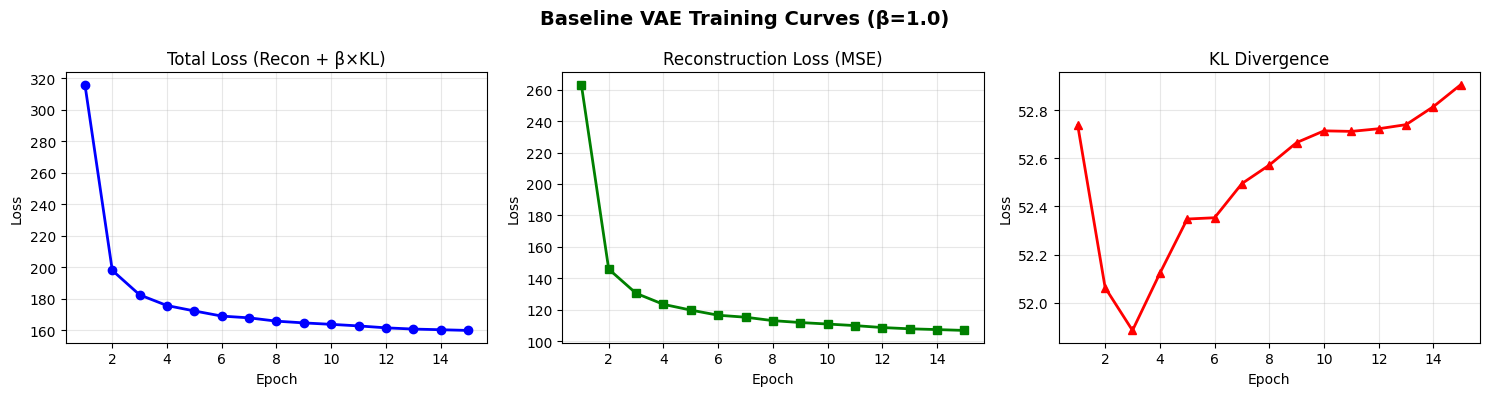

In [15]:
# Plot training curves
def plot_training_curves(history, title="Training Curves"):
    """Plot training loss curves."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    epochs = range(1, len(history['total_loss']) + 1)
    
    # Total Loss
    axes[0].plot(epochs, history['total_loss'], 'b-', linewidth=2, marker='o')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Total Loss (Recon + β×KL)')
    axes[0].grid(True, alpha=0.3)
    
    # Reconstruction Loss
    axes[1].plot(epochs, history['recon_loss'], 'g-', linewidth=2, marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Reconstruction Loss (MSE)')
    axes[1].grid(True, alpha=0.3)
    
    # KL Divergence
    axes[2].plot(epochs, history['kl_loss'], 'r-', linewidth=2, marker='^')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].set_title('KL Divergence')
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'results_portfolio3/{title.lower().replace(" ", "_")}.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_training_curves(baseline_history, "Baseline VAE Training Curves (β=1.0)")

---
## Task 2: Latent Space Exploration

Now we'll explore the learned latent space through:
1. **Reconstructions**: Compare original vs. reconstructed images
2. **Interpolations**: Smooth transitions between pairs of images
3. **Traversals**: Effect of varying individual latent dimensions

### 2.1 Image Reconstructions

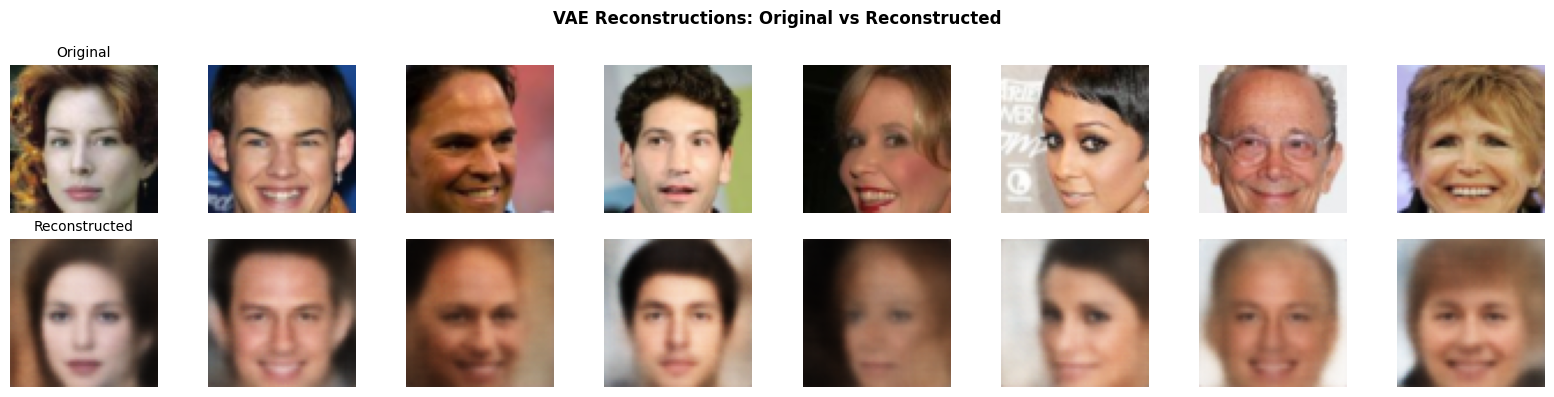

Average reconstruction MSE: 0.008674


In [16]:
def visualize_reconstructions(model, data_loader, num_images=8, device='cuda'):
    """Visualize original vs reconstructed images."""
    model.eval()
    
    # Get a batch of test images
    images, _ = next(iter(data_loader))
    images = images[:num_images].to(device)
    
    with torch.no_grad():
        recon, _, _ = model(images)
    
    # Create comparison figure
    fig, axes = plt.subplots(2, num_images, figsize=(2*num_images, 4))
    
    for i in range(num_images):
        # Original
        axes[0, i].imshow(images[i].cpu().permute(1, 2, 0).numpy())
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=10)
        
        # Reconstruction
        axes[1, i].imshow(np.clip(recon[i].cpu().permute(1, 2, 0).numpy(), 0, 1))
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed', fontsize=10)
    
    plt.suptitle('VAE Reconstructions: Original vs Reconstructed', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results_portfolio3/reconstructions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Calculate reconstruction error
    mse = F.mse_loss(recon, images).item()
    print(f"Average reconstruction MSE: {mse:.6f}")

visualize_reconstructions(vae, test_loader, num_images=8, device=device)

### 2.2 Latent Space Interpolations

We perform linear interpolation between pairs of images in the latent space to visualize smooth transitions.

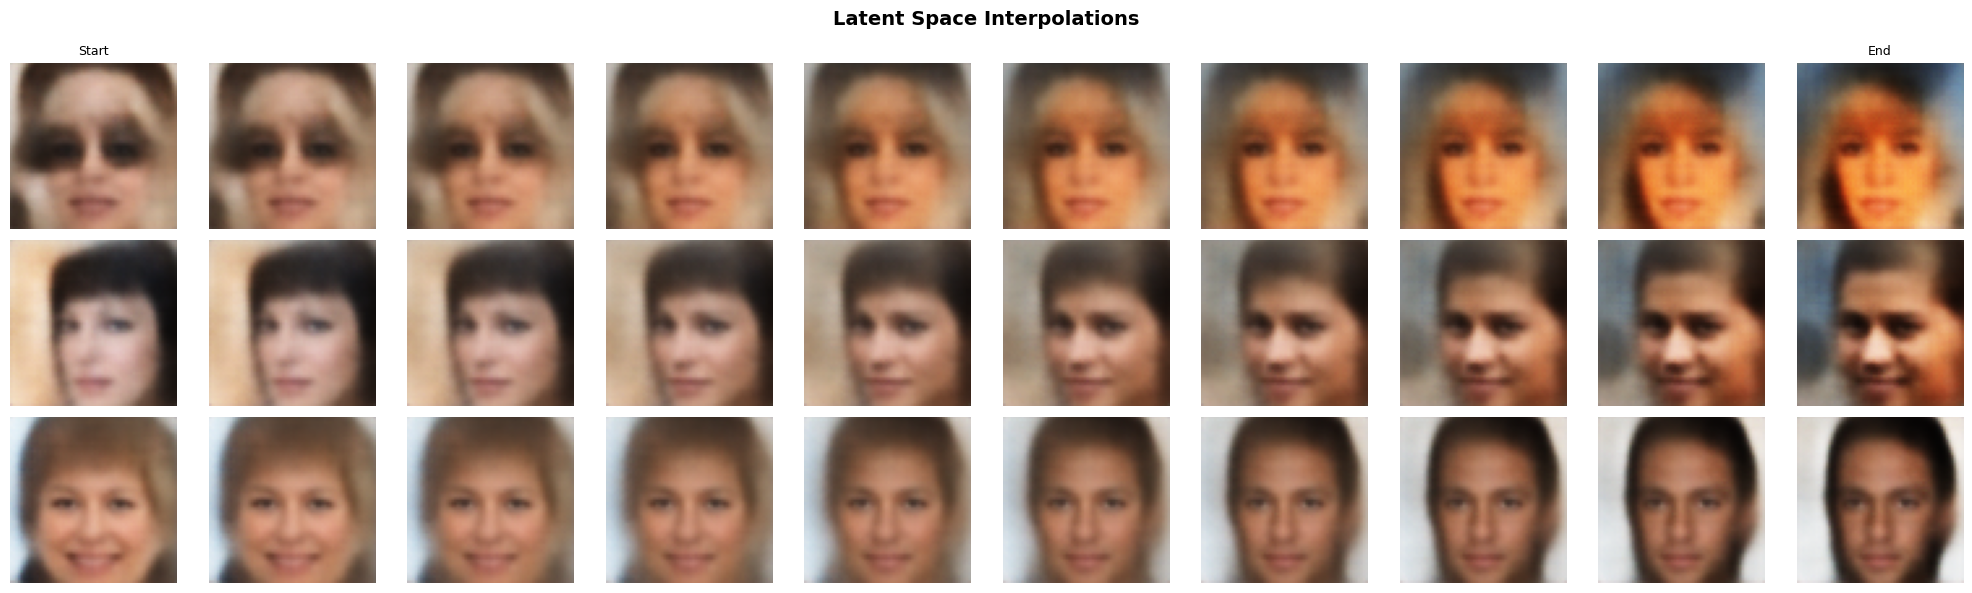

In [17]:
def latent_interpolation(model, img1, img2, num_steps=10, device='cuda'):
    """Interpolate between two images in latent space."""
    model.eval()
    
    with torch.no_grad():
        # Encode both images
        z1, _, _ = model.encode(img1.unsqueeze(0).to(device))
        z2, _, _ = model.encode(img2.unsqueeze(0).to(device))
        
        # Linear interpolation
        interpolations = []
        for alpha in np.linspace(0, 1, num_steps):
            z_interp = (1 - alpha) * z1 + alpha * z2
            img_interp = model.decode(z_interp)
            interpolations.append(img_interp.squeeze(0).cpu())
    
    return interpolations


def visualize_interpolations(model, data_loader, num_pairs=3, num_steps=10, device='cuda'):
    """Visualize latent space interpolations between image pairs."""
    model.eval()
    
    # Get test images
    images, _ = next(iter(data_loader))
    
    # AUTOMATIC SELECTION: Find pairs with MAXIMUM difference
    with torch.no_grad():
        # Encode all images
        all_mu = []
        for img in images[:50]:  # Check first 50 images
            mu, _ = model.encoder(img.unsqueeze(0).to(device))
            all_mu.append(mu.squeeze(0))
        all_mu = torch.stack(all_mu)
        
        # Find most different pairs based on latent distance
        selected_pairs = []
        for _ in range(num_pairs):
            max_dist = 0
            best_pair = (0, 1)
            for i in range(len(all_mu)):
                if i in [p[0] for p in selected_pairs] or i in [p[1] for p in selected_pairs]:
                    continue
                for j in range(i+1, len(all_mu)):
                    if j in [p[0] for p in selected_pairs] or j in [p[1] for p in selected_pairs]:
                        continue
                    dist = torch.dist(all_mu[i], all_mu[j]).item()
                    if dist > max_dist:
                        max_dist = dist
                        best_pair = (i, j)
            selected_pairs.append(best_pair)
    
    fig, axes = plt.subplots(num_pairs, num_steps, figsize=(2*num_steps, 2*num_pairs))
    
    for pair_idx, (idx1, idx2) in enumerate(selected_pairs):
        img1 = images[idx1]
        img2 = images[idx2]
        
        interpolations = latent_interpolation(model, img1, img2, num_steps, device)
        
        for step_idx, interp_img in enumerate(interpolations):
            axes[pair_idx, step_idx].imshow(np.clip(interp_img.permute(1, 2, 0).numpy(), 0, 1))
            axes[pair_idx, step_idx].axis('off')
            
            if pair_idx == 0:
                if step_idx == 0:
                    axes[pair_idx, step_idx].set_title('Start', fontsize=9)
                elif step_idx == num_steps - 1:
                    axes[pair_idx, step_idx].set_title('End', fontsize=9)
    
    plt.suptitle('Latent Space Interpolations', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results_portfolio3/interpolations.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_interpolations(vae, test_loader, num_pairs=3, num_steps=10, device=device)

### 2.3 Latent Dimension Traversals

We vary individual latent dimensions to see their effect on generated images. This helps understand what features each dimension encodes.

Most influential dimensions: [74, 50, 2, 20, 43, 46]
Impact scores: ['0.0982', '0.0638', '0.0565', '0.0518', '0.0510', '0.0350']


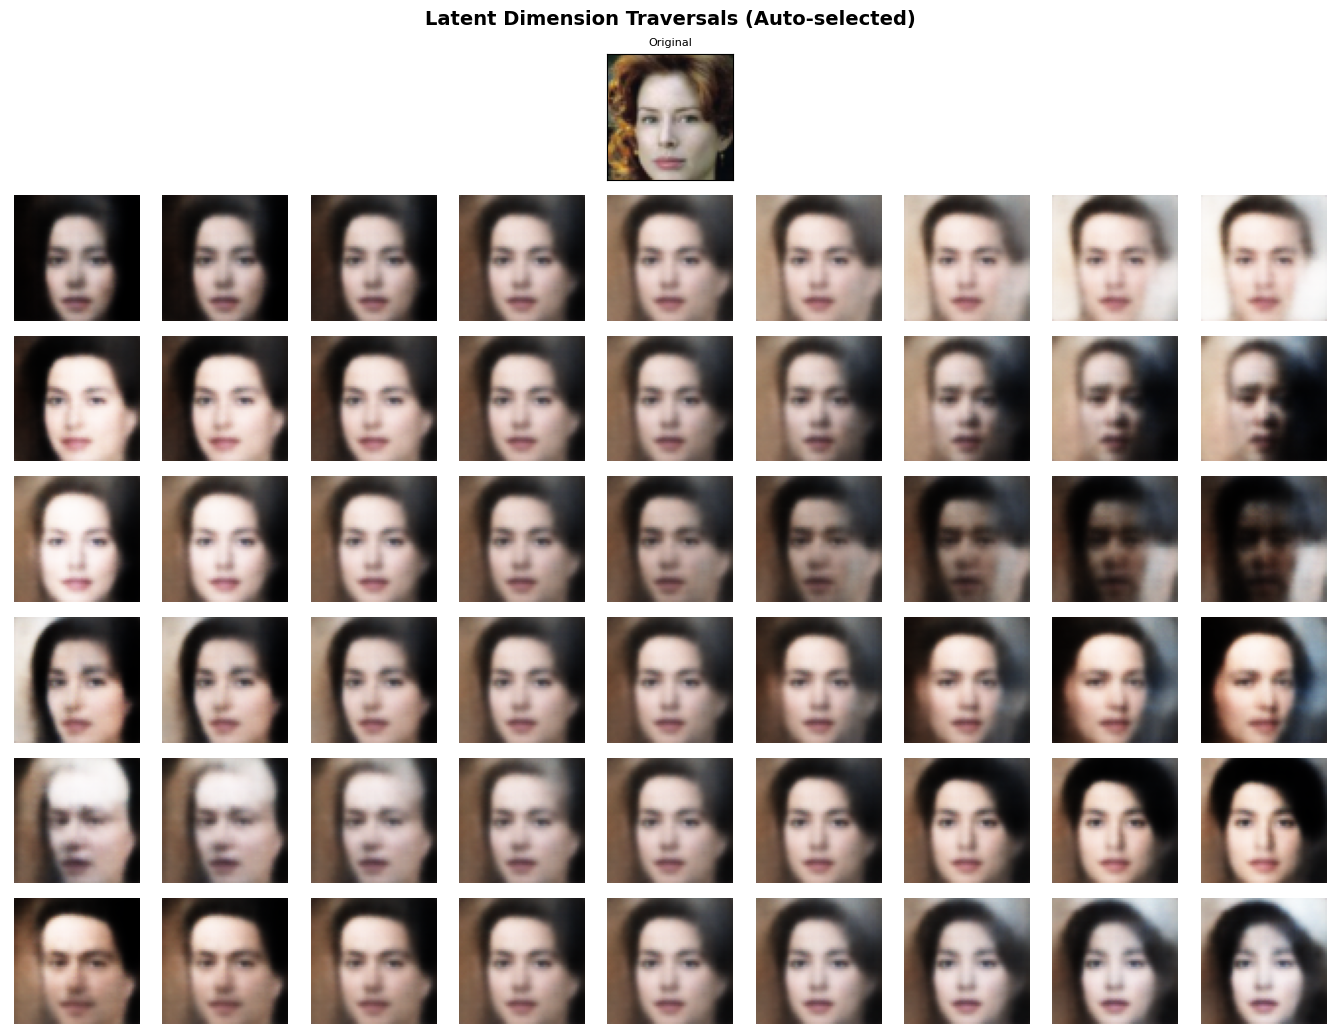

In [18]:
def latent_traversal(model, base_image, dims_to_traverse, range_val=3.0, num_steps=9, device='cuda'):
    """Traverse individual latent dimensions."""
    model.eval()
    
    with torch.no_grad():
        # Encode the base image
        z, _, _ = model.encode(base_image.unsqueeze(0).to(device))
        
        traversals = {}
        for dim in dims_to_traverse:
            dim_traversal = []
            for val in np.linspace(-range_val, range_val, num_steps):
                z_modified = z.clone()
                z_modified[0, dim] = val
                img = model.decode(z_modified)
                dim_traversal.append(img.squeeze(0).cpu())
            traversals[dim] = dim_traversal
    
    return traversals


def find_most_influential_dimensions(model, data_loader, latent_dim, device='cuda', top_k=6):
    """Find dimensions that cause the biggest visual changes."""
    model.eval()
    
    images, _ = next(iter(data_loader))
    base_image = images[0].to(device)
    
    with torch.no_grad():
        z_base, _, _ = model.encode(base_image.unsqueeze(0))
        base_recon = model.decode(z_base)
        
        dimension_impact = []
        
        for dim in range(latent_dim):
            # Test both directions
            z_pos = z_base.clone()
            z_pos[0, dim] += 3.0
            z_neg = z_base.clone()
            z_neg[0, dim] -= 3.0
            
            recon_pos = model.decode(z_pos)
            recon_neg = model.decode(z_neg)
            
            # Measure visual change
            diff_pos = torch.mean((recon_pos - base_recon) ** 2).item()
            diff_neg = torch.mean((recon_neg - base_recon) ** 2).item()
            total_diff = diff_pos + diff_neg
            
            dimension_impact.append((dim, total_diff))
        
        # Sort by impact and return top K
        dimension_impact.sort(key=lambda x: x[1], reverse=True)
        top_dims = [dim for dim, _ in dimension_impact[:top_k]]
        
        print(f"Most influential dimensions: {top_dims}")
        print(f"Impact scores: {[f'{score:.4f}' for _, score in dimension_impact[:top_k]]}")
        
        return top_dims


def visualize_traversals(model, data_loader, num_dims=6, range_val=3.0, num_steps=9, device='cuda'):
    """Visualize latent dimension traversals."""
    model.eval()
    
    # Get a test image
    images, _ = next(iter(data_loader))
    base_image = images[0]
    
    # AUTOMATICALLY FIND BEST DIMENSIONS
    dims_to_traverse = find_most_influential_dimensions(model, data_loader, LATENT_DIM, device, num_dims)
    
    traversals = latent_traversal(model, base_image, dims_to_traverse, range_val, num_steps, device)
    
    fig, axes = plt.subplots(num_dims + 1, num_steps, figsize=(num_steps * 1.5, (num_dims + 1) * 1.5))
    
    # Show original image in the first row (center column)
    center_idx = num_steps // 2
    for i in range(num_steps):
        if i == center_idx:
            axes[0, i].imshow(base_image.permute(1, 2, 0).numpy())
            axes[0, i].set_title('Original', fontsize=8)
        else:
            axes[0, i].axis('off')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
    
    # Show traversals
    for row_idx, dim in enumerate(dims_to_traverse):
        for col_idx, img in enumerate(traversals[dim]):
            axes[row_idx + 1, col_idx].imshow(np.clip(img.permute(1, 2, 0).numpy(), 0, 1))
            axes[row_idx + 1, col_idx].axis('off')
        
        # Label the dimension
        axes[row_idx + 1, 0].set_ylabel(f'Dim {dim}', fontsize=9, rotation=0, ha='right', va='center')
    
    # Add column labels
    for col_idx, val in enumerate(np.linspace(-range_val, range_val, num_steps)):
        axes[-1, col_idx].set_xlabel(f'{val:.1f}', fontsize=8)
    
    plt.suptitle('Latent Dimension Traversals (Auto-selected)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results_portfolio3/traversals.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_traversals(vae, test_loader, num_dims=6, range_val=5.0, device=device)

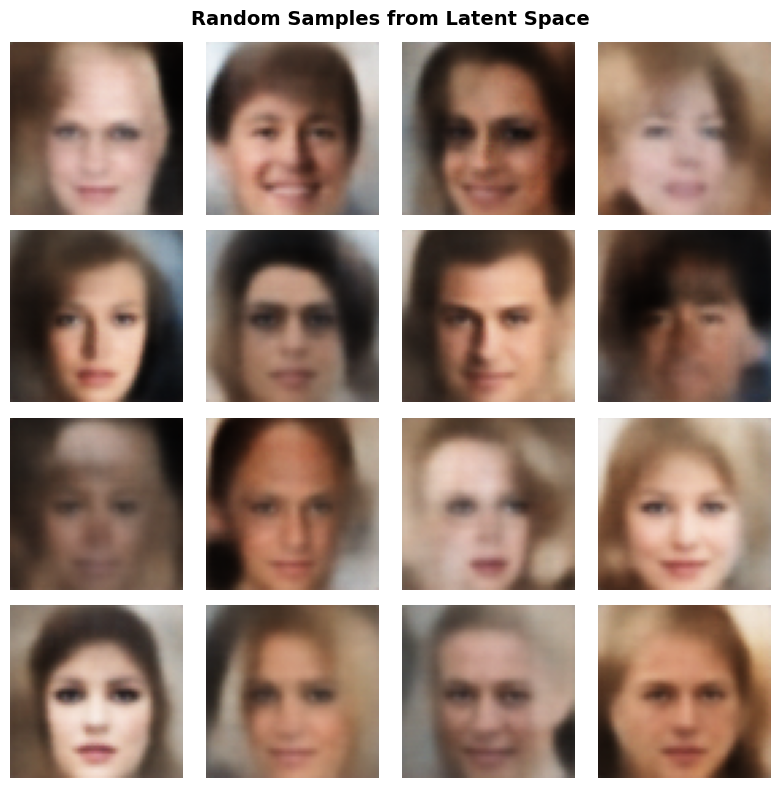

In [19]:
# Generate random samples from the latent space
def visualize_random_samples(model, num_samples=16, device='cuda'):
    """Generate and visualize random samples from the latent space."""
    model.eval()
    
    with torch.no_grad():
        samples = model.sample(num_samples, device)
    
    nrow = int(np.sqrt(num_samples))
    fig, axes = plt.subplots(nrow, nrow, figsize=(2*nrow, 2*nrow))
    
    for i in range(nrow):
        for j in range(nrow):
            idx = i * nrow + j
            axes[i, j].imshow(np.clip(samples[idx].cpu().permute(1, 2, 0).numpy(), 0, 1))
            axes[i, j].axis('off')
    
    plt.suptitle('Random Samples from Latent Space', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results_portfolio3/random_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_random_samples(vae, num_samples=16, device=device)

---
## Task 3: β-VAE Variant

The β-VAE introduces a hyperparameter β that controls the trade-off between reconstruction quality and latent space disentanglement:
- **β = 1**: Standard VAE
- **β > 1**: Stronger regularization → more disentangled latent space, but potentially worse reconstructions
- **β < 1**: Weaker regularization → better reconstructions, but less structured latent space

We'll train models with β = 0.5, 2.0, and 4.0 and compare the results.

In [20]:
# Train β-VAE variants
beta_values = [0.5, 4.0]  # Different β values to compare
beta_models = {}
beta_histories = {}

for beta in beta_values:
    print(f"\n{'='*50}")
    print(f"Training β-VAE with β = {beta}")
    print(f"{'='*50}")
    
    # Initialize model
    beta_vae = VAE(latent_dim=LATENT_DIM, beta=beta).to(device)
    
    # Train
    history = train_vae(
        beta_vae, 
        train_loader, 
        epochs=NUM_EPOCHS, 
        device=device, 
        model_name=f'beta_vae_{beta}'
    )
    
    beta_models[beta] = beta_vae
    beta_histories[beta] = history


Training β-VAE with β = 0.5


Epoch 1/15: 100%|██████████| 235/235 [00:29<00:00,  8.10it/s, loss=172.19, recon=131.24, kl=81.89] 


Epoch 1: Total Loss = 270.8801, Recon = 229.1170, KL = 83.5262


Epoch 2/15: 100%|██████████| 235/235 [00:29<00:00,  8.06it/s, loss=151.68, recon=111.23, kl=80.90]


Epoch 2: Total Loss = 164.5281, Recon = 123.2433, KL = 82.5696


Epoch 3/15: 100%|██████████| 235/235 [00:30<00:00,  7.71it/s, loss=144.90, recon=105.60, kl=78.59]


Epoch 3: Total Loss = 148.6861, Recon = 107.9202, KL = 81.5319


Epoch 4/15: 100%|██████████| 235/235 [00:29<00:00,  7.93it/s, loss=143.68, recon=102.55, kl=82.27]


Epoch 4: Total Loss = 141.9293, Recon = 100.9065, KL = 82.0456


Epoch 5/15: 100%|██████████| 235/235 [00:30<00:00,  7.73it/s, loss=141.59, recon=99.20, kl=84.78] 


Epoch 5: Total Loss = 138.0283, Recon = 96.8638, KL = 82.3290


Epoch 6/15: 100%|██████████| 235/235 [00:29<00:00,  8.07it/s, loss=131.09, recon=88.69, kl=84.80] 


Epoch 6: Total Loss = 134.8988, Recon = 93.6888, KL = 82.4201


Epoch 7/15: 100%|██████████| 235/235 [00:29<00:00,  7.88it/s, loss=136.37, recon=94.30, kl=84.14] 


Epoch 7: Total Loss = 132.9030, Recon = 91.6086, KL = 82.5888


Epoch 8/15: 100%|██████████| 235/235 [00:29<00:00,  7.85it/s, loss=122.91, recon=82.91, kl=80.01] 


Epoch 8: Total Loss = 131.0196, Recon = 89.6979, KL = 82.6434


Epoch 9/15: 100%|██████████| 235/235 [00:30<00:00,  7.77it/s, loss=135.44, recon=95.90, kl=79.07]


Epoch 9: Total Loss = 129.8396, Recon = 88.4610, KL = 82.7572


Epoch 10/15: 100%|██████████| 235/235 [00:29<00:00,  7.86it/s, loss=135.53, recon=93.67, kl=83.71]


Epoch 10: Total Loss = 128.5118, Recon = 87.0773, KL = 82.8690


Epoch 11/15: 100%|██████████| 235/235 [00:29<00:00,  7.88it/s, loss=122.48, recon=84.31, kl=76.35]


Epoch 11: Total Loss = 127.5313, Recon = 86.0121, KL = 83.0384


Epoch 12/15: 100%|██████████| 235/235 [00:30<00:00,  7.82it/s, loss=132.46, recon=88.59, kl=87.74]


Epoch 12: Total Loss = 127.1781, Recon = 85.5284, KL = 83.2993


Epoch 13/15: 100%|██████████| 235/235 [00:29<00:00,  7.86it/s, loss=123.47, recon=82.72, kl=81.48]


Epoch 13: Total Loss = 125.6946, Recon = 83.9185, KL = 83.5523


Epoch 14/15: 100%|██████████| 235/235 [00:29<00:00,  7.85it/s, loss=128.14, recon=84.81, kl=86.67] 


Epoch 14: Total Loss = 125.5812, Recon = 83.7665, KL = 83.6293


Epoch 15/15: 100%|██████████| 235/235 [00:30<00:00,  7.79it/s, loss=124.03, recon=82.97, kl=82.11]


Epoch 15: Total Loss = 124.7354, Recon = 82.8720, KL = 83.7267
Model saved to results_portfolio3/beta_vae_0.5.pth

Training β-VAE with β = 4.0


Epoch 1/15: 100%|██████████| 235/235 [00:29<00:00,  7.87it/s, loss=337.00, recon=244.54, kl=23.12] 


Epoch 1: Total Loss = 419.4804, Recon = 337.7500, KL = 20.4326


Epoch 2/15: 100%|██████████| 235/235 [00:29<00:00,  7.89it/s, loss=281.98, recon=201.41, kl=20.14]


Epoch 2: Total Loss = 293.1669, Recon = 215.9936, KL = 19.2933


Epoch 3/15: 100%|██████████| 235/235 [00:30<00:00,  7.63it/s, loss=273.68, recon=204.19, kl=17.37]


Epoch 3: Total Loss = 281.0105, Recon = 202.8038, KL = 19.5517


Epoch 4/15: 100%|██████████| 235/235 [00:30<00:00,  7.66it/s, loss=281.55, recon=202.88, kl=19.67]


Epoch 4: Total Loss = 274.8099, Recon = 196.6962, KL = 19.5284


Epoch 5/15: 100%|██████████| 235/235 [00:30<00:00,  7.64it/s, loss=262.36, recon=179.84, kl=20.63]


Epoch 5: Total Loss = 271.4016, Recon = 192.9474, KL = 19.6136


Epoch 6/15: 100%|██████████| 235/235 [00:30<00:00,  7.69it/s, loss=267.40, recon=188.12, kl=19.82]


Epoch 6: Total Loss = 268.2957, Recon = 189.6822, KL = 19.6534


Epoch 7/15: 100%|██████████| 235/235 [00:30<00:00,  7.74it/s, loss=266.32, recon=188.87, kl=19.36]


Epoch 7: Total Loss = 265.6235, Recon = 186.2823, KL = 19.8353


Epoch 8/15: 100%|██████████| 235/235 [00:30<00:00,  7.81it/s, loss=267.42, recon=185.34, kl=20.52]


Epoch 8: Total Loss = 264.4911, Recon = 184.4385, KL = 20.0132


Epoch 9/15: 100%|██████████| 235/235 [00:34<00:00,  6.88it/s, loss=257.56, recon=174.26, kl=20.83]


Epoch 9: Total Loss = 262.2347, Recon = 181.7151, KL = 20.1299


Epoch 10/15: 100%|██████████| 235/235 [00:33<00:00,  7.10it/s, loss=258.20, recon=181.54, kl=19.17]


Epoch 10: Total Loss = 260.7740, Recon = 180.1028, KL = 20.1678


Epoch 11/15: 100%|██████████| 235/235 [00:32<00:00,  7.24it/s, loss=262.11, recon=181.72, kl=20.10]


Epoch 11: Total Loss = 259.8531, Recon = 178.9974, KL = 20.2139


Epoch 12/15: 100%|██████████| 235/235 [00:32<00:00,  7.21it/s, loss=258.97, recon=175.01, kl=20.99]


Epoch 12: Total Loss = 258.6527, Recon = 177.9671, KL = 20.1714


Epoch 13/15: 100%|██████████| 235/235 [00:31<00:00,  7.47it/s, loss=274.37, recon=190.30, kl=21.02]


Epoch 13: Total Loss = 257.9460, Recon = 177.0627, KL = 20.2208


Epoch 14/15: 100%|██████████| 235/235 [00:31<00:00,  7.42it/s, loss=266.21, recon=187.61, kl=19.65]


Epoch 14: Total Loss = 257.7048, Recon = 176.8307, KL = 20.2185


Epoch 15/15: 100%|██████████| 235/235 [00:31<00:00,  7.47it/s, loss=265.83, recon=178.65, kl=21.80]


Epoch 15: Total Loss = 256.5657, Recon = 175.6295, KL = 20.2340
Model saved to results_portfolio3/beta_vae_4.0.pth


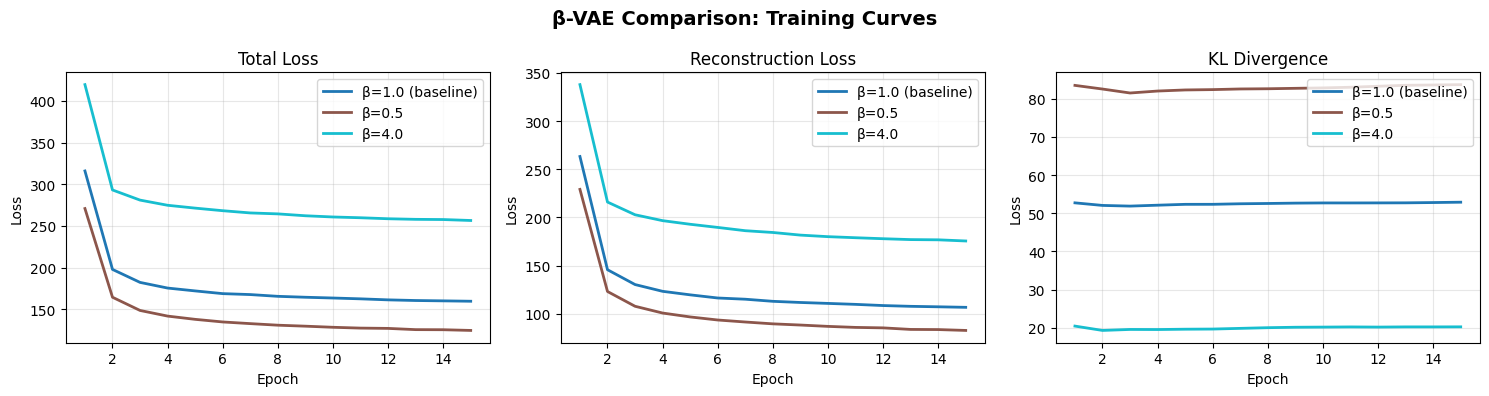

In [21]:
# Compare training curves for different β values
def plot_beta_comparison(baseline_history, beta_histories):
    """Compare training curves for different β values."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    all_histories = {'β=1.0 (baseline)': baseline_history}
    all_histories.update({f'β={beta}': hist for beta, hist in beta_histories.items()})
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_histories)))
    
    for (label, history), color in zip(all_histories.items(), colors):
        epochs = range(1, len(history['total_loss']) + 1)
        
        axes[0].plot(epochs, history['total_loss'], label=label, linewidth=2, color=color)
        axes[1].plot(epochs, history['recon_loss'], label=label, linewidth=2, color=color)
        axes[2].plot(epochs, history['kl_loss'], label=label, linewidth=2, color=color)
    
    axes[0].set_title('Total Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_title('Reconstruction Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    axes[2].set_title('KL Divergence')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle('β-VAE Comparison: Training Curves', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results_portfolio3/beta_comparison_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_beta_comparison(baseline_history, beta_histories)

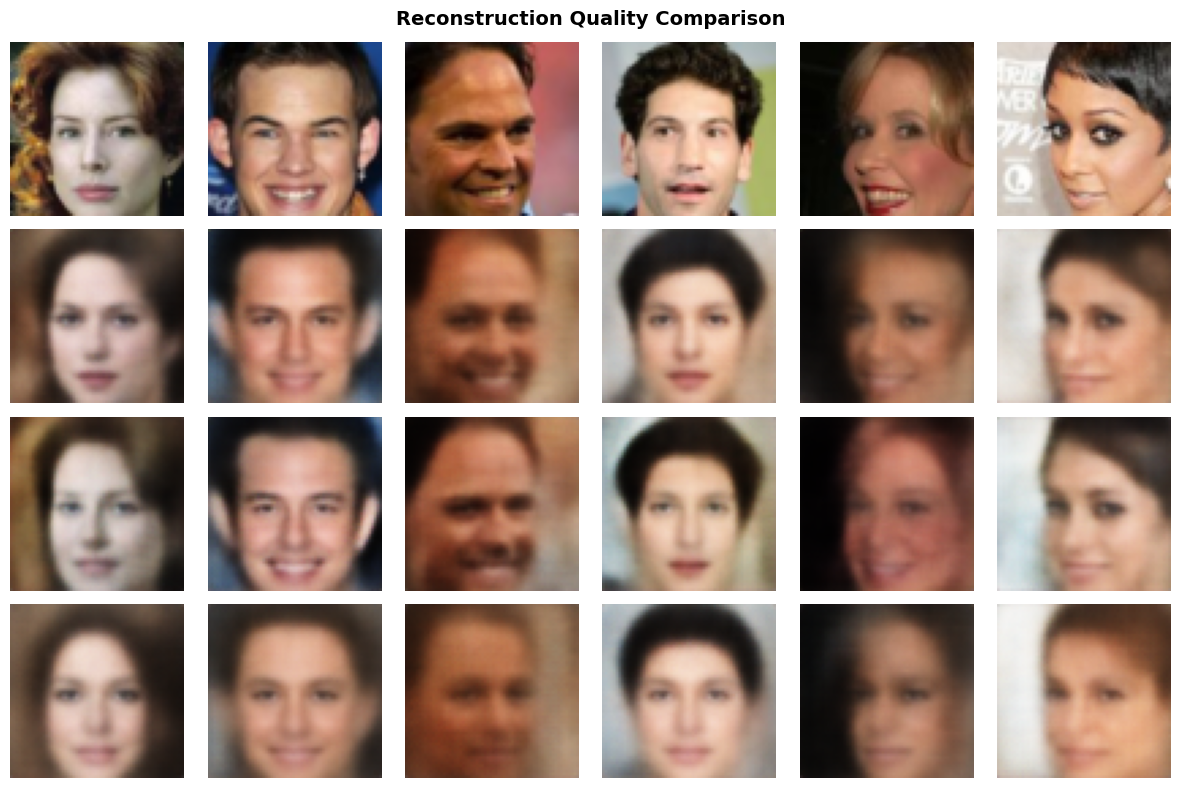

In [22]:
# Compare reconstructions for different β values
def compare_reconstructions(models_dict, data_loader, num_images=6, device='cuda'):
    """Compare reconstructions across different β values."""
    # Get test images
    images, _ = next(iter(data_loader))
    images = images[:num_images].to(device)
    
    num_models = len(models_dict) + 1  # +1 for original
    
    fig, axes = plt.subplots(num_models, num_images, figsize=(2*num_images, 2*num_models))
    
    # Original images
    for i in range(num_images):
        axes[0, i].imshow(images[i].cpu().permute(1, 2, 0).numpy())
        axes[0, i].axis('off')
    axes[0, 0].set_ylabel('Original', fontsize=10, rotation=0, ha='right', va='center')
    
    # Reconstructions for each model
    for row_idx, (label, model) in enumerate(models_dict.items(), 1):
        model.eval()
        with torch.no_grad():
            recon, _, _ = model(images)
        
        for i in range(num_images):
            axes[row_idx, i].imshow(np.clip(recon[i].cpu().permute(1, 2, 0).numpy(), 0, 1))
            axes[row_idx, i].axis('off')
        axes[row_idx, 0].set_ylabel(label, fontsize=10, rotation=0, ha='right', va='center')
    
    plt.suptitle('Reconstruction Quality Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results_portfolio3/beta_reconstructions_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# Prepare models dictionary
all_models = {'β=1.0': vae}
all_models.update({f'β={beta}': model for beta, model in beta_models.items()})

compare_reconstructions(all_models, test_loader, num_images=6, device=device)

Most influential dimensions: [74]
Impact scores: ['0.0968']
Using dimension 74 for comparison


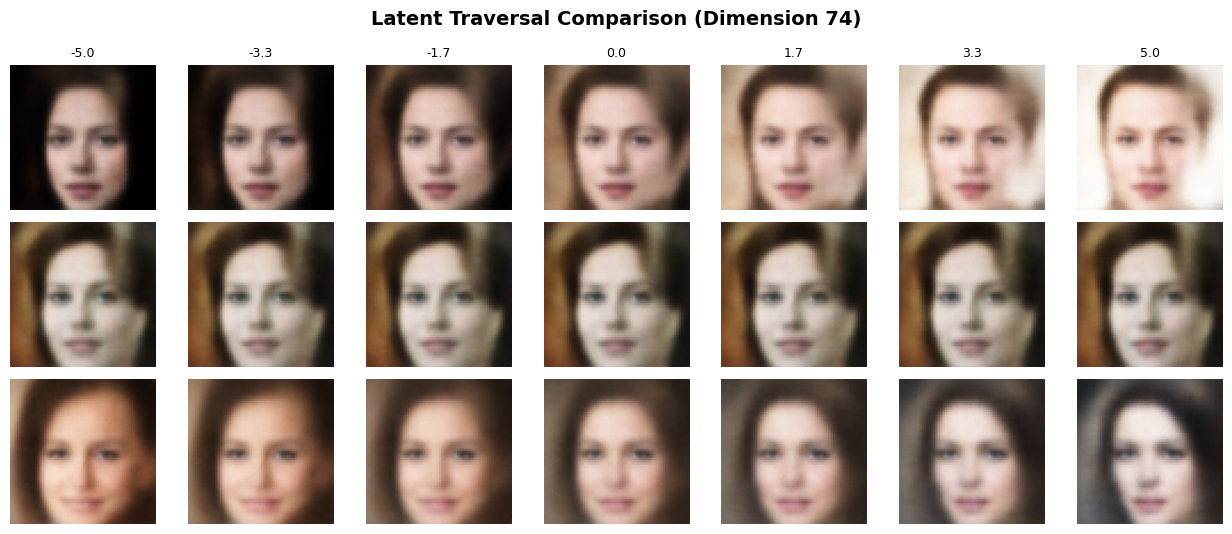

In [23]:
# Compare latent traversals for different β values - AUTO VERSION
def compare_traversals_auto(models_dict, data_loader, range_val=5.0, num_steps=7, device='cuda'):
    """Compare latent traversals across different β values on best dimension."""
    
    # Get a test image
    images, _ = next(iter(data_loader))
    base_image = images[0]
    
    # Find best dimension for baseline model
    best_dim = find_most_influential_dimensions(models_dict['β=1.0'], data_loader, LATENT_DIM, device, top_k=1)[0]
    print(f"Using dimension {best_dim} for comparison")
    
    num_models = len(models_dict)
    
    fig, axes = plt.subplots(num_models, num_steps, figsize=(num_steps * 1.8, num_models * 1.8))
    
    for row_idx, (label, model) in enumerate(models_dict.items()):
        model.eval()
        
        with torch.no_grad():
            z, _, _ = model.encode(base_image.unsqueeze(0).to(device))
            
            for col_idx, val in enumerate(np.linspace(-range_val, range_val, num_steps)):
                z_modified = z.clone()
                z_modified[0, best_dim] = val
                img = model.decode(z_modified)
                
                axes[row_idx, col_idx].imshow(np.clip(img.squeeze(0).cpu().permute(1, 2, 0).numpy(), 0, 1))
                axes[row_idx, col_idx].axis('off')
                
                if row_idx == 0:
                    axes[row_idx, col_idx].set_title(f'{val:.1f}', fontsize=9)
            
            axes[row_idx, 0].set_ylabel(label, fontsize=10, rotation=0, ha='right', va='center')
    
    plt.suptitle(f'Latent Traversal Comparison (Dimension {best_dim})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results_portfolio3/beta_traversals_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

compare_traversals_auto(all_models, test_loader, range_val=5.0, device=device)

Most influential dimensions: [111]
Impact scores: ['0.0927']
Most influential dimensions: [74]
Impact scores: ['0.0925']
Most influential dimensions: [56]
Impact scores: ['0.1540']


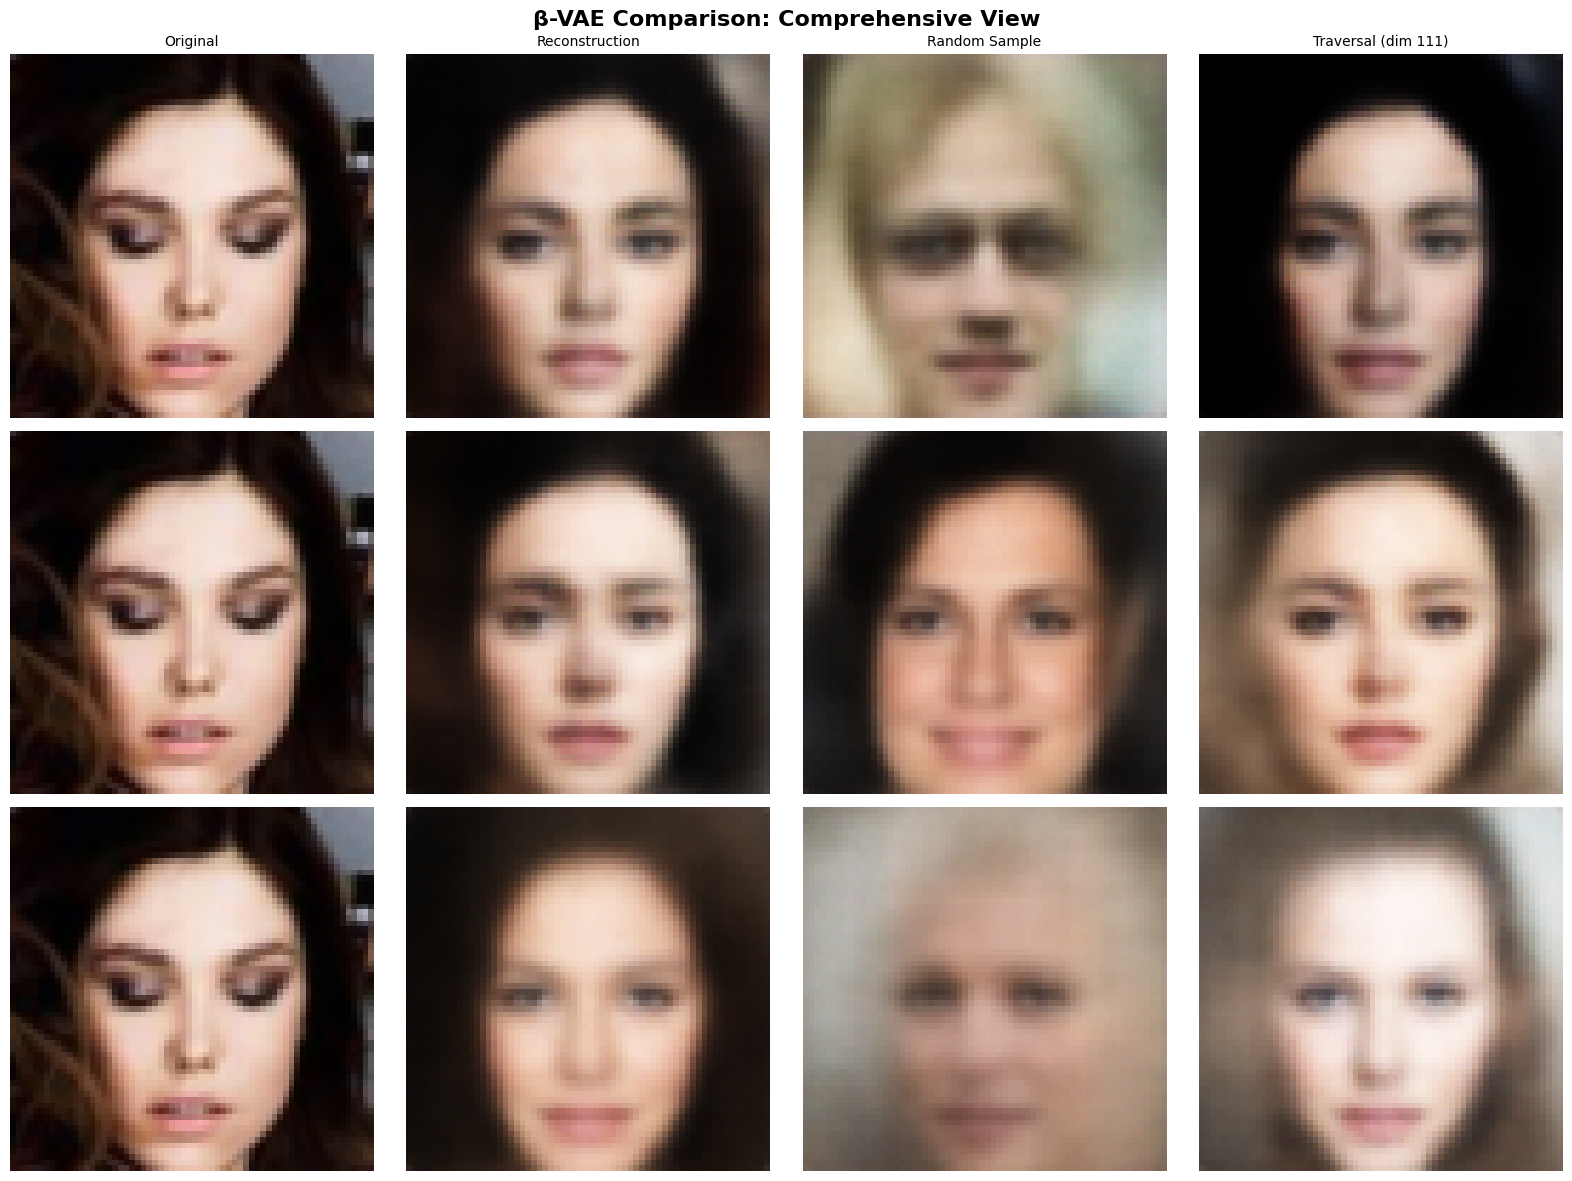

In [24]:
def compare_beta_extremes(models_dict, data_loader, device='cuda'):
    """Show extreme examples where β differences are most visible."""
    
    # Get diverse test images
    images, _ = next(iter(data_loader))
    
    # Find image with lots of detail (high variance)
    variances = [torch.var(img).item() for img in images[:50]]
    detailed_idx = np.argmax(variances)
    detailed_img = images[detailed_idx].unsqueeze(0).to(device)
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    
    model_list = [('β=0.5', models_dict['β=0.5']), 
                  ('β=1.0', models_dict['β=1.0']), 
                  ('β=4.0', models_dict['β=4.0'])]
    
    for row_idx, (label, model) in enumerate(model_list):
        model.eval()
        
        with torch.no_grad():
            # Original
            axes[row_idx, 0].imshow(detailed_img.squeeze(0).cpu().permute(1, 2, 0).numpy())
            axes[row_idx, 0].set_title('Original' if row_idx == 0 else '', fontsize=10)
            axes[row_idx, 0].axis('off')
            axes[row_idx, 0].set_ylabel(label, fontsize=12, rotation=0, ha='right', va='center')
            
            # Reconstruction
            recon, _, _ = model(detailed_img)
            axes[row_idx, 1].imshow(np.clip(recon.squeeze(0).cpu().permute(1, 2, 0).numpy(), 0, 1))
            axes[row_idx, 1].set_title('Reconstruction' if row_idx == 0 else '', fontsize=10)
            axes[row_idx, 1].axis('off')
            
            # Random sample
            z_random = torch.randn(1, LATENT_DIM).to(device)
            sample = model.decode(z_random)
            axes[row_idx, 2].imshow(np.clip(sample.squeeze(0).cpu().permute(1, 2, 0).numpy(), 0, 1))
            axes[row_idx, 2].set_title('Random Sample' if row_idx == 0 else '', fontsize=10)
            axes[row_idx, 2].axis('off')
            
            # Traversal on best dimension
            best_dims = find_most_influential_dimensions(model, data_loader, LATENT_DIM, device, top_k=1)
            z, _, _ = model.encode(detailed_img)
            z_mod = z.clone()
            z_mod[0, best_dims[0]] += 3.0
            traversal = model.decode(z_mod)
            axes[row_idx, 3].imshow(np.clip(traversal.squeeze(0).cpu().permute(1, 2, 0).numpy(), 0, 1))
            axes[row_idx, 3].set_title(f'Traversal (dim {best_dims[0]})' if row_idx == 0 else '', fontsize=10)
            axes[row_idx, 3].axis('off')
    
    plt.suptitle('β-VAE Comparison: Comprehensive View', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results_portfolio3/beta_comprehensive_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# RUN THIS AFTER TRAINING ALL MODELS
compare_beta_extremes(all_models, test_loader, device=device)

In [25]:
# Quantitative comparison
def evaluate_models(models_dict, data_loader, device='cuda'):
    """Evaluate and compare models quantitatively."""
    results = {}
    
    for label, model in models_dict.items():
        model.eval()
        total_recon_loss = 0
        total_kl_loss = 0
        num_batches = 0
        
        with torch.no_grad():
            for images, _ in data_loader:
                images = images.to(device)
                recon, mu, logvar = model(images)
                
                # Reconstruction loss (MSE)
                recon_loss = F.mse_loss(recon, images, reduction='sum') / images.size(0)
                
                # KL divergence
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / images.size(0)
                
                total_recon_loss += recon_loss.item()
                total_kl_loss += kl_loss.item()
                num_batches += 1
                
                if num_batches >= 10:  # Evaluate on subset for speed
                    break
        
        avg_recon = total_recon_loss / num_batches
        avg_kl = total_kl_loss / num_batches
        
        results[label] = {
            'Reconstruction Loss': avg_recon,
            'KL Divergence': avg_kl,
            'Total Loss': avg_recon + float(label.split('=')[1].rstrip(')')) * avg_kl if '=' in label else avg_recon + avg_kl
        }
    
    # Print results table
    print("\n" + "="*70)
    print("Model Evaluation Results (on Test Set)")
    print("="*70)
    print(f"{'Model':<15} {'Recon Loss':<15} {'KL Divergence':<15}")
    print("-"*70)
    for label, metrics in results.items():
        print(f"{label:<15} {metrics['Reconstruction Loss']:<15.4f} {metrics['KL Divergence']:<15.4f}")
    print("="*70)
    
    return results

evaluation_results = evaluate_models(all_models, test_loader, device=device)


Model Evaluation Results (on Test Set)
Model           Recon Loss      KL Divergence  
----------------------------------------------------------------------
β=1.0           107.9849        52.7252        
β=0.5           83.0382         85.0217        
β=4.0           171.9194        20.6896        


---
## Summary and Discussion

### Key Findings

#### 1. Baseline VAE (β=1.0)
- Achieves good reconstruction quality while maintaining a regularized latent space
- Training converges smoothly with both reconstruction and KL losses decreasing
- Latent space allows for meaningful interpolations between faces

#### 2. β-VAE Trade-offs
- **β < 1 (e.g., β=0.5)**: Better reconstruction quality but potentially less disentangled latent space
- **β > 1 (e.g., β=4.0)**: More regularized/disentangled latent space but blurrier reconstructions

#### 3. Latent Space Properties
- Interpolations show smooth transitions between faces
- Traversals reveal that different dimensions capture different facial features
- Higher β values tend to produce cleaner traversals but at the cost of reconstruction fidelity

### Architecture Decisions
- **Latent dimension (128)**: Balances expressiveness with regularization
- **Convolutional architecture**: Efficient for image data, captures spatial hierarchies
- **MSE loss**: Works better for face reconstruction than BCE
- **Batch normalization**: Stabilizes training
- **LeakyReLU**: Prevents dead neurons

### Limitations and Future Work
- Could explore different latent dimensions
- Conditional VAE to control specific attributes
- Perceptual loss for sharper reconstructions
- More sophisticated disentanglement metrics

In [26]:
# Final summary visualization
print("\n" + "="*70)
print("PORTFOLIO 3 SUMMARY")
print("="*70)
print(f"\nDataset: CelebA (64x64 images)")
print(f"Latent Dimension: {LATENT_DIM}")
print(f"Training Epochs: {NUM_EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"\nModels Trained:")
print(f"  - Baseline VAE (β=1.0)")
for beta in beta_values:
    print(f"  - β-VAE (β={beta})")
print(f"\nOutputs saved in: results_portfolio3/")
print("  - baseline_vae.pth")
for beta in beta_values:
    print(f"  - beta_vae_{beta}.pth")
print("  - reconstructions.png")
print("  - interpolations.png")
print("  - traversals.png")
print("  - random_samples.png")
print("  - beta_comparison_curves.png")
print("  - beta_reconstructions_comparison.png")
print("  - beta_traversals_comparison.png")
print("="*70)


PORTFOLIO 3 SUMMARY

Dataset: CelebA (64x64 images)
Latent Dimension: 128
Training Epochs: 15
Batch Size: 128

Models Trained:
  - Baseline VAE (β=1.0)
  - β-VAE (β=0.5)
  - β-VAE (β=4.0)

Outputs saved in: results_portfolio3/
  - baseline_vae.pth
  - beta_vae_0.5.pth
  - beta_vae_4.0.pth
  - reconstructions.png
  - interpolations.png
  - traversals.png
  - random_samples.png
  - beta_comparison_curves.png
  - beta_reconstructions_comparison.png
  - beta_traversals_comparison.png
